<p style="font-size:20px; color:orange; text-align:center"><b>This is a project to get started with recommendation systems!</b></p>

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/moviesratings/ratings.csv
/kaggle/input/movies/movies.csv



<p style="font-size:18px; color:orange;">Below we can see the types of recommender systems, In this notebook the focus is going to be on Collaborative systems</p>

<img src='https://www.alpha-quantum.com/blog/wp-content/uploads/2020/05/img_5ed4354677fb7.png'>

# Import Data

In [2]:
movies_df = pd.read_csv('/kaggle/input/movies/movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating_df=pd.read_csv('/kaggle/input/moviesratings/ratings.csv',usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [3]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Merge Datasets and Explore

In [5]:
df=pd.merge(movies_df,rating_df,on='movieId')

In [6]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [7]:
rate_count=pd.DataFrame(df.groupby('title').size(), columns=['RateCount']).reset_index()

In [8]:
rate_count.head()

,title,RateCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [9]:
movie_rating=pd.merge(df,rate_count,on='title')

In [10]:
movie_rating.head()

,movieId,title,userId,rating,RateCount
0,1,Toy Story (1995),1,4.0,215
1,1,Toy Story (1995),5,4.0,215
2,1,Toy Story (1995),7,4.5,215
3,1,Toy Story (1995),15,2.5,215
4,1,Toy Story (1995),17,4.5,215


In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
rate_count.RateCount.describe()

count   9719.00
mean      10.38
std       22.41
min        1.00
25%        1.00
50%        3.00
75%        9.00
max      329.00
Name: RateCount, dtype: float64

<AxesSubplot:>

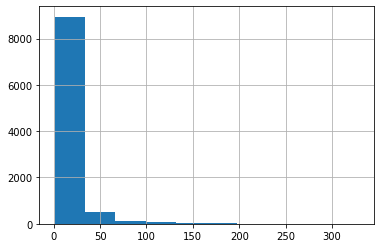

In [12]:
rate_count.RateCount.hist()

In [13]:
popularity_threshold = 50 #since the majority of the rate counts are below 50
rating_popular_movie= movie_rating.query('RateCount >= @popularity_threshold')
rating_popular_movie.head()

,movieId,title,userId,rating,RateCount
0,1,Toy Story (1995),1,4.00,215
1,1,Toy Story (1995),5,4.00,215
2,1,Toy Story (1995),7,4.50,215
3,1,Toy Story (1995),15,2.50,215
4,1,Toy Story (1995),17,4.50,215


# Pivot_table To Prepare Data For Using Cosine Similarity

In [14]:
#now we create a pivot tabel with user id as columns and titles as index
#This table is going to help us with cosine similarity
pivot_movie=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)

In [15]:
pivot_movie.head() 

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,3.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00
12 Angry Men (1957),0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2001: A Space Odyssey (1968),0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,...,0.00,0.00,5.00,0.00,0.00,5.00,0.00,3.00,0.00,4.50
28 Days Later (2002),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,5.00
300 (2007),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,...,0.00,0.00,0.00,0.00,3.00,0.00,0.00,5.00,0.00,4.00


## A little about cosine similarity

<p style= 'font-size:18px;'><i>In data analysis, cosine similarity is a measure of similarity between two sequences of numbers. a simple example is the picture below, we have two 2-D vectors, similarity between vector A and vector B, determines whether two vectors are pointing in roughly the same direction, so we compute cos(&Theta;) where &Theta; is the angle between them, if it's 0 then the similarity is 1 and if it's 90, the similarity is 0.</i></p>

<img src='https://media-exp2.licdn.com/dms/image/C4E12AQF9Q-nIc3bkhQ/article-inline_image-shrink_1500_2232/0/1535343574742?e=1662595200&v=beta&t=SrmavGUZPwK0bJgcqZ0akENhBEe-aZ30W_O5ViP-XVs' width=500>

In [16]:
# we are going to convert this pivot table to an array matrix using csr_matrix
from scipy.sparse import csr_matrix
pivot_movie_matrix = csr_matrix(pivot_movie.values)
#Note that we are using nearest neighbors, this is unsupervised and NOT the same as knn supervised model
from sklearn.neighbors import NearestNeighbors
model_nn = NearestNeighbors(metric = 'cosine', algorithm = 'auto')
model_nn.fit(pivot_movie_matrix)

NearestNeighbors(metric='cosine')

In [17]:
pivot_movie_matrix.shape

(450, 606)

# Testing the System

In [18]:
#for testing, we are going to randomly choose a row (a movie)
query_index = np.random.choice(pivot_movie_matrix.shape[0])
query_index

426

In [19]:
# we use kneighbors to find similar movies to movie at query_index row
# we want 6 most similar movies to the chosen movie, so n_neighbors is 6
distances, indices = model_nn.kneighbors(pivot_movie.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [20]:
indices

array([[426, 324,  91, 317, 393, 134]])

In [21]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(pivot_movie.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, pivot_movie.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Vertigo (1958):

1: Rear Window (1954), with distance of 0.41472184658050537:
2: Chinatown (1974), with distance of 0.42166703939437866:
3: Psycho (1960), with distance of 0.4653524160385132:
4: Taxi Driver (1976), with distance of 0.46543580293655396:
5: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), with distance of 0.48561227321624756:


# Reference:
[This YT video](https://www.youtube.com/watch?v=kccT0FVK6OY&list=PLZoTAELRMXVN7QGpcuN-Vg35Hgjp3htvi&index=3)